In [901]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklego.linear_model import LowessRegression
from sklearn import decomposition

In [902]:
data = pd.read_csv("../Dataset/Chen2019/data.csv")

In [903]:
threshold = 1000

In [904]:
table = data.iloc[:, 1:].transpose()
table.index = list(range(len(table)))
mirnas = data.iloc[:, 0]

In [905]:
table = table.drop([1, 4, 20])

In [906]:
mask = table.mean()>threshold
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [907]:
mirnas

1        hsa-let-7a-5p
3        hsa-let-7b-5p
5        hsa-let-7c-5p
6        hsa-let-7d-3p
7        hsa-let-7d-5p
             ...      
1141    hsa-miR-625-5p
1147    hsa-miR-629-5p
1486    hsa-miR-92a-3p
1506    hsa-miR-99a-5p
1508    hsa-miR-99b-5p
Name: miRNA, Length: 75, dtype: object

In [908]:
table.head()

,1,3,5,6,7,12,14,16,18,19,...,894,895,983,990,1102,1141,1147,1486,1506,1508
0,6504.479293,36055.276130,1273.827034,2814.361604,1228.048875,3546.812148,10027.407180,6814.974633,2728.776350,6170.099697,...,4064.304381,28921.84474,2953.686436,3618.464919,8602.313190,3413.458381,605.067841,27723.651190,28802.423460,1570.389891
2,9437.584674,22678.699510,1381.345556,1388.590375,912.847238,4607.705107,9336.157203,6556.561512,9022.215031,5489.158128,...,4436.244382,26489.47448,2980.035693,618.224585,16491.623780,3144.251598,1072.233264,20415.900930,46127.764800,1714.607246
3,1307.373304,11133.759750,267.097772,98.404442,238.982217,2656.919941,2839.671048,2263.302172,2502.284389,899.697758,...,6677.444296,46601.53230,435.791101,421.733324,281.155549,28.115555,1026.217755,9376.537569,4470.373234,140.577775
5,3172.157520,15241.461610,619.325992,1253.757496,226.582680,1888.189000,2613.253576,1404.812616,1616.289784,815.697648,...,3353.423664,19138.68371,287.004728,1540.762224,6646.425281,438.059848,422.954336,15724.837990,12688.630080,1676.711832
6,1624.959376,6568.775175,502.260171,1940.103013,68.937670,1723.441762,1733.290001,2442.363183,2639.327956,2924.926877,...,2127.219547,14220.85660,610.590796,915.886194,5899.094947,246.205966,541.653125,11286.081480,17086.694040,669.680228


In [909]:
sick = np.array(["cancer" in k for k in data.columns[1:]])
sick = np.delete(sick, [1, 4, 20])
controls = 1 - sick

In [910]:
sick

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [911]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [912]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

In [913]:
def mean_std_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, np.sqrt(variances))
    plt.xlabel("mean")
    plt.ylabel("std dev")
    plt.plot()

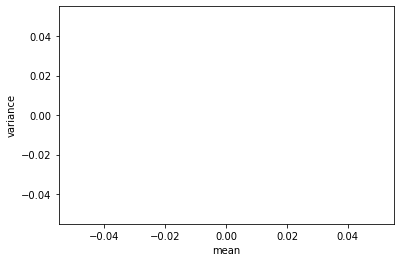

In [914]:
mean_variance_plot(table.loc[:, np.mean(table) < 1000])

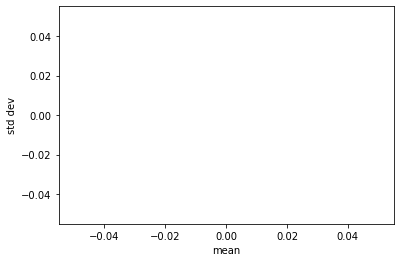

In [915]:
mean_std_plot(table.loc[:, np.mean(table) < 1000])

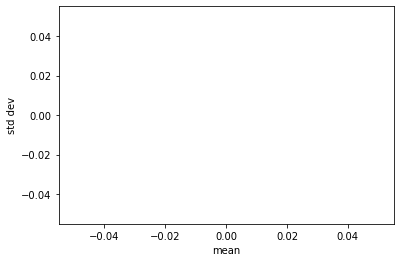

In [916]:
mean_std_plot(table.loc[:, np.logical_and(np.mean(table) < 1000, 3 * np.mean(table) > np.std(table))])

In [917]:
len(3 * np.mean(table) > np.std(table)), len(mirnas)

(75, 75)

In [918]:
mask = 3 * np.mean(table) > np.std(table)
table = table.loc[:, mask]
mirnas = mirnas[mask]

### Log transformation

In [919]:
log_table = np.log2(table + 1)

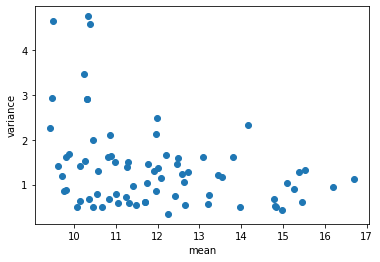

In [920]:
mean_variance_plot(log_table)

In [921]:
mask = np.mean(log_table) > 5
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Loess regression

In [922]:
lowess = LowessRegression(sigma=1, span=0.1)

In [923]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [924]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

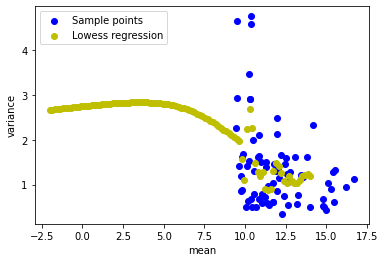

In [925]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [926]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [927]:
log_table /= np.sqrt(adj_var)

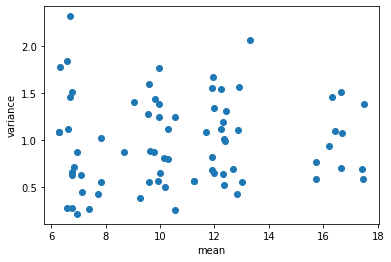

In [928]:
mean_variance_plot(log_table)

In [929]:
norm_log_table = log_table - np.mean(log_table)

In [930]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

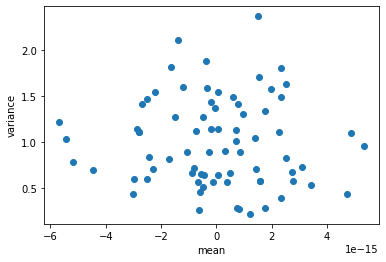

In [931]:
mean_variance_plot(norm_log_table)

# PCA

In [932]:
pca = decomposition.PCA(n_components=2)

In [933]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [934]:
components = pca.transform(norm_log_table)

In [935]:
components

array([[-1.94662699, -5.01898021],
       [ 1.34949873, -4.34986255],
       [18.02270718,  0.78721571],
       [ 9.58723864, -6.83150601],
       [ 7.84724253, -6.59156503],
       [18.96896002, -0.80943248],
       [ 0.46862134, -1.16698264],
       [-1.11092767, -3.11966923],
       [ 2.14262473,  0.15668876],
       [ 5.63219368,  2.40414455],
       [ 0.31250547, -1.93148838],
       [ 3.47827109,  1.02768571],
       [ 7.13048638, -3.01828793],
       [10.40611281, -1.67832542],
       [ 6.26542721, -6.19786568],
       [-3.06740526, -4.73870342],
       [ 1.51822479,  3.14197391],
       [-5.30065544,  0.1012865 ],
       [-3.33916463, -0.96136163],
       [-0.31083985,  5.85053605],
       [-4.78411094,  2.94110416],
       [-6.57435063, -2.81646367],
       [-6.37198956, -2.89577488],
       [ 1.25996935,  5.1619909 ],
       [-4.81568947,  0.68840482],
       [-5.75314227,  1.63177054],
       [-2.33710836,  3.36752226],
       [ 0.1608694 ,  8.1983174 ],
       [ 0.07195134,

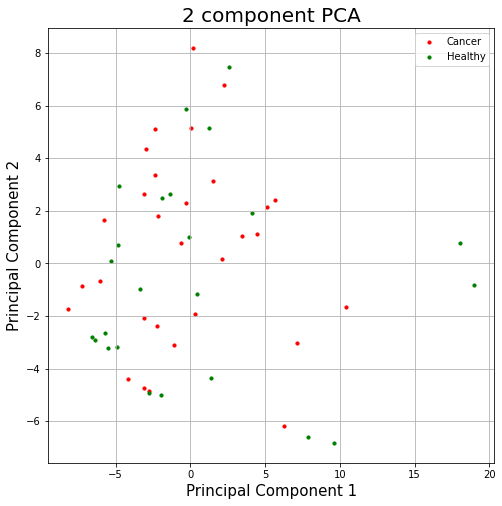

In [936]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [937]:
np.nonzero(components[:, 0] > 30)

(array([], dtype=int64),)

### Export dataset

In [938]:
from Scripts import converters

In [939]:
mirnas

1        hsa-let-7a-5p
3        hsa-let-7b-5p
5        hsa-let-7c-5p
6        hsa-let-7d-3p
7        hsa-let-7d-5p
             ...      
1141    hsa-miR-625-5p
1147    hsa-miR-629-5p
1486    hsa-miR-92a-3p
1506    hsa-miR-99a-5p
1508    hsa-miR-99b-5p
Name: miRNA, Length: 75, dtype: object

In [940]:
sequences = converters.canonical_to_seq(mirnas)

In [941]:
sequences[:10]

['UGAGGUAGUAGGUUGUAUAGUU',
 'UGAGGUAGUAGGUUGUGUGGUU',
 'UGAGGUAGUAGGUUGUAUGGUU',
 'CUAUACGACCUGCUGCCUUUCU',
 'AGAGGUAGUAGGUUGCAUAGUU',
 'UGAGGUAGUAGAUUGUAUAGUU',
 'UGAGGUAGUAGUUUGUACAGUU',
 'UGAGGUAGUAGUUUGUGCUGUU',
 'AACCCGUAGAUCCGAACUUGUG',
 'UACAGUACUGUGAUAACUGAA']

In [942]:
sequences = np.array(sequences)
mirnas[sequences == "ACAGUAGUCUGCACAUUGGUUA"]

254    hsa-miR-199a-3p
256    hsa-miR-199b-3p
Name: miRNA, dtype: object

In [943]:
np.nonzero([sequences == "ACAGUAGUCUGCACAUUGGUUA"])

(array([0, 0], dtype=int64), array([33, 34], dtype=int64))

In [944]:
sequences = np.delete(sequences, [71])
norm_log_table = norm_log_table.drop(norm_log_table.columns[71], 1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_30960/890718696.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  norm_log_table = norm_log_table.drop(norm_log_table.columns[71], 1)


In [945]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,UGAGGUAGUAGGUUGUAUAGUU,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,UGAGGUAGUAGUUUGUGCUGUU,AACCCGUAGAUCCGAACUUGUG,UACAGUACUGUGAUAACUGAA,...,CGGGGCAGCUCAGUACAGGAU,UCCUGUACUGAGCUGCCCCGAG,CAUGCCUUGAGUGUAGGACCGU,AAACAUUCGCGGUGCACUUCUU,UUAUGGUUUGCCUGGGACUGAG,AGGGGGAAAGUUCUAUAGUCC,UAUUGCACUUGUCCCGGCCUGU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
0,-1.041973,0.376914,-1.014168,0.548958,-0.486054,-1.289866,-0.227077,-0.477344,-0.067140,0.179172,...,-0.650604,-0.695072,0.650432,1.800017,0.763109,1.596269,-0.040578,0.781230,0.644920,False
2,-0.553673,-0.341690,-0.889299,-0.395460,-0.868969,-0.913725,-0.322454,-0.531334,1.803752,0.015421,...,-0.525781,-0.833185,0.662308,-0.555438,1.583074,1.511821,-0.515185,1.411284,0.747037,False
3,-3.146347,-1.444369,-3.418710,-3.923333,-2.596745,-1.705072,-1.911575,-2.016724,-0.202680,-2.516102,...,0.057170,0.054908,-1.906668,-1.064689,-3.542870,-3.303017,-1.722099,-1.710931,-2.154211,False
5,-1.983930,-0.957643,-2.125011,-0.531979,-2.665297,-2.195917,-2.022499,-2.682554,-0.886283,-2.653216,...,-0.924660,-1.344186,-2.463754,0.661520,0.438133,-0.512894,-0.920141,-0.315425,0.721061,False
6,-2.861217,-2.262146,-2.447533,0.051612,-4.189956,-2.327105,-2.570537,-1.910408,-0.119275,-0.865998,...,-1.573402,-1.811107,-1.456417,-0.031795,0.287863,-1.103558,-1.434595,0.082686,-0.345266,False


In [946]:
norm_log_table.to_csv(f"../TransformedData/Chen2019_threshold_{threshold}.csv", index=False)